# 03 - Sélection du Modèle

**Objectif**: Choisir le meilleur modèle de classification.

**Méthodologie**:
- **Vectorization fixée**: Configuration optimale de Notebook 02
- **Preprocessing**: `final_text_cleaner()` (Notebook 01)
- **Variables testées**: Différents modèles (LogReg, SVM, XGBoost, RF)

**Output**: Meilleur modèle → `models/production_pipeline.pkl`

In [1]:
import sys
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '../src')
sys.path.insert(0, '../scripts')

from rakuten_text import (
    final_text_cleaner,
    extract_text_features,
    load_vectorization_config,
    get_config_summary,
    get_available_models,
    build_full_pipeline,
    train_and_evaluate,
)

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Import data loading with consistent split
from load_data import split_data

print("✓ Imports réussis")

✓ Imports réussis


## 2. Chargement de la Configuration Optimale

In [2]:
# Afficher la configuration
get_config_summary('results/configs/best_vectorization_config.json')

# Charger la configuration en tant que dictionnaire
import json
with open('results/configs/best_vectorization_config.json', 'r') as f:
    config = json.load(f)

# Charger le vectorizer
print("\nConstruction du vectorizer...")
vectorizer = load_vectorization_config('results/configs/best_vectorization_config.json')

RÉSUMÉ DE LA CONFIGURATION

Vectorizer: TFIDF
Strategy: Split
N-gram range: [1, 1]
Max features (title): 20000
Max features (desc): 20000
Min df: 2
Max df: 0.95
Features manuelles: 12 colonnes

Métadonnées:
  f1_score: 0.8351405676166618
  accuracy: 0.8344878544379791
  train_time: 33.681057929992676
  notebook: 02_Vectorization_Strategies.ipynb
  baseline_f1: 0.7858
  improvement_pct: 6.279023621361889
  title_weight: 1.5

Construction du vectorizer...
Configuration chargée depuis: results/configs/best_vectorization_config.json
  Vectorizer: tfidf
  Strategy: split
✓ Vectorizer construit avec succès


## 3. Préparation des Données

In [3]:
print("=" * 80)
print("Data Loading and Splitting")
print("=" * 80)

X_dev, X_holdout, y_dev, y_holdout = split_data()

# Prepare dataframes
df_dev = X_dev.copy()
df_dev['prdtypecode'] = y_dev

df_holdout = X_holdout.copy()
df_holdout['prdtypecode'] = y_holdout

print(f"✓ Data loaded: {len(df_dev) + len(df_holdout):,} total samples")
print(f"✓ Development: {len(df_dev):,} samples (85%)")
print(f"✓ Hold-out:    {len(df_holdout):,} samples (15%)")

# Apply preprocessing
print("\n" + "=" * 80)
print("Preprocessing")
print("=" * 80)

df_dev['title_clean'] = df_dev['designation'].fillna('').apply(final_text_cleaner)
df_dev['desc_clean'] = df_dev['description'].fillna('').apply(final_text_cleaner)

df_holdout['title_clean'] = df_holdout['designation'].fillna('').apply(final_text_cleaner)
df_holdout['desc_clean'] = df_holdout['description'].fillna('').apply(final_text_cleaner)

print("✓ Texts cleaned")

# Feature Engineering
print("\n" + "=" * 80)
print("Feature Engineering")
print("=" * 80)

if config.get('feature_columns'):
    print("Extracting manual features...")
    features_dev = extract_text_features(df_dev, verbose=False)
    features_holdout = extract_text_features(df_holdout, verbose=False)
    
    for col in features_dev.columns:
        df_dev[col] = features_dev[col]
        df_holdout[col] = features_holdout[col]
    
    print(f"✓ {len(features_dev.columns)} features extracted")
else:
    print("✓ No manual features (config)")

# Development Split (Train/Val)
print("\n" + "=" * 80)
print("Development Split (Train/Val)")
print("=" * 80)

VAL_SIZE = 0.15
RANDOM_STATE = 42

X_train, X_val, y_train, y_val = train_test_split(
    df_dev,
    df_dev['prdtypecode'],
    test_size=VAL_SIZE,
    stratify=df_dev['prdtypecode'],
    random_state=RANDOM_STATE
)

total_samples = len(df_dev) + len(df_holdout)
print(f"✓ Split complete:")
print(f"  Train:      {len(X_train):,} (~{len(X_train)/total_samples*100:.1f}%)")
print(f"  Validation: {len(X_val):,} (~{len(X_val)/total_samples*100:.1f}%)")
print(f"  Hold-out:   {len(df_holdout):,} (15.0%)")

print("\n⚠️  Model selection will use Train/Val only")
print("⚠️  Hold-out will be evaluated at the end")
print("=" * 80)

Data Loading and Splitting
✓ Data loaded: 84,916 total samples
✓ Development: 72,178 samples (85%)
✓ Hold-out:    12,738 samples (15%)

Preprocessing
✓ Texts cleaned

Feature Engineering
Extracting manual features...
✓ 12 features extracted

Development Split (Train/Val)
✓ Split complete:
  Train:      61,351 (~72.2%)
  Validation: 10,827 (~12.8%)
  Hold-out:   12,738 (15.0%)

⚠️  Model selection will use Train/Val only
⚠️  Hold-out will be evaluated at the end


## 4. Test de Tous les Modèles

In [4]:
from sklearn.preprocessing import LabelEncoder

models_to_test = get_available_models()
print(f"Modèles à tester: {models_to_test}\n")

# Créer un label encoder pour XGBoost (il nécessite des labels 0, 1, 2, ... au lieu de 10, 40, 50, ...)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

results = []

for model_name in models_to_test:
    print(f"\n{'='*70}")
    print(f"Test: {model_name.upper()}")
    print(f"{'='*70}")
    
    try:
        # Pour XGBoost, encoder les labels en 0, 1, 2, ...
        if model_name == 'xgboost':
            y_train_encoded = label_encoder.transform(y_train)
            y_val_encoded = label_encoder.transform(y_val)
        else:
            y_train_encoded = y_train
            y_val_encoded = y_val
        
        pipeline = build_full_pipeline(vectorizer, model_name=model_name)
        result = train_and_evaluate(pipeline, X_train, y_train_encoded, X_val, y_val_encoded, verbose=True)
        
        results.append({
            'model': model_name,
            'f1_score': result['f1_score'],
            'accuracy': result['accuracy'],
            'train_time': result['train_time'],
            'predict_time': result['predict_time'],
            'pipeline': result['pipeline']
        })
    except Exception as e:
        print(f"❌ Erreur: {e}")
        continue

df_results = pd.DataFrame([{k: v for k, v in r.items() if k != 'pipeline'} for r in results])
df_results = df_results.sort_values('f1_score', ascending=False)

print("\n" + "="*70)
print("RÉSULTATS COMPARATIFS")
print("="*70)
print(df_results.to_string(index=False))

Modèles à tester: ['logreg', 'svm', 'xgboost', 'rf']


Test: LOGREG
Entraînement du pipeline...
✓ Entraînement terminé en 37.20s

RÉSULTATS DE L'ÉVALUATION
F1-Score (weighted): 0.8351
Accuracy:            0.8345
Temps prédiction:    1.31s

Rapport de classification:
--------------------------------------------------------------------------------
                        precision    recall  f1-score   support

     Livres techniques       0.50      0.65      0.57       397
          Rétro Gaming       0.73      0.72      0.73       320
        Accessoires JV       0.84      0.83      0.83       214
              Consoles       0.94      0.77      0.85       106
              Figurine       0.79      0.79      0.79       341
Cartes à collectionner       0.94      0.95      0.94       504
          Jeux de rôle       0.89      0.60      0.72        97
    Jouets & Figurines       0.73      0.76      0.74       621
        Jeux éducatifs       0.71      0.57      0.63       264
    Modélis

## 5. Visualisations

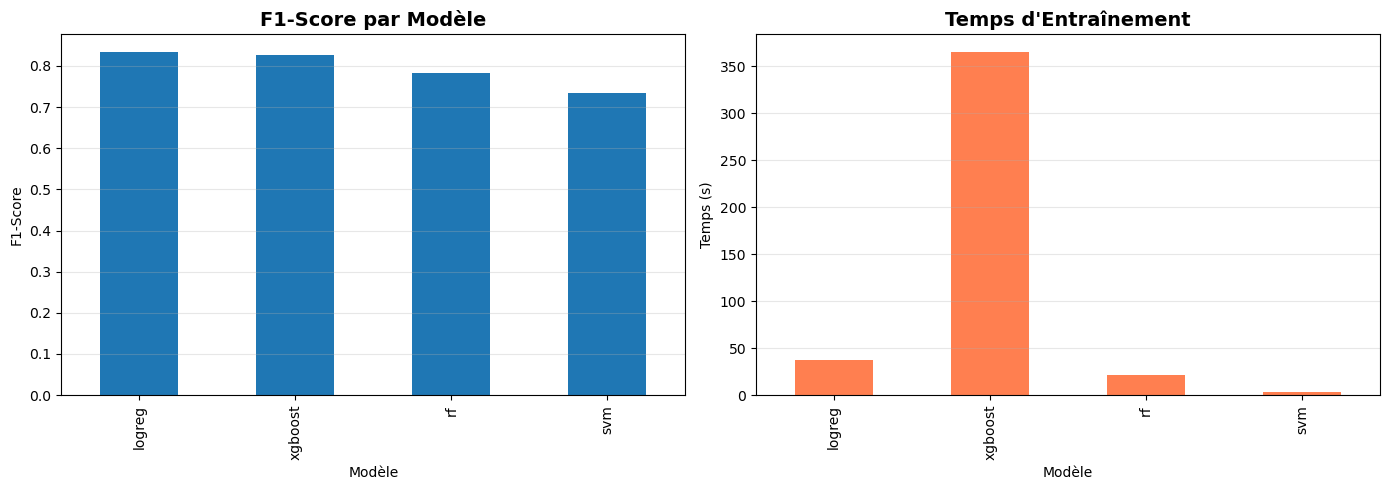

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1-Score
ax1 = axes[0]
df_results.plot(x='model', y='f1_score', kind='bar', ax=ax1, legend=False)
ax1.set_title('F1-Score par Modèle', fontsize=14, fontweight='bold')
ax1.set_xlabel('Modèle')
ax1.set_ylabel('F1-Score')
ax1.grid(alpha=0.3, axis='y')

# Train time
ax2 = axes[1]
df_results.plot(x='model', y='train_time', kind='bar', ax=ax2, legend=False, color='coral')
ax2.set_title('Temps d\'Entraînement', fontsize=14, fontweight='bold')
ax2.set_xlabel('Modèle')
ax2.set_ylabel('Temps (s)')
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. Meilleur Modèle & Export

In [ ]:
best_idx = df_results.index[0]
best_result = [r for r in results if r['model'] == df_results.iloc[0]['model']][0]

print("="*70)
print("🏆 MEILLEUR MODÈLE")
print("="*70)
print(f"Modèle: {best_result['model'].upper()}")
print(f"F1-Score: {best_result['f1_score']:.4f}")
print(f"Accuracy: {best_result['accuracy']:.4f}")
print(f"Train time: {best_result['train_time']:.2f}s")
print(f"Predict time: {best_result['predict_time']:.2f}s")
print("="*70)

# Sauvegarder le meilleur modèle
from datetime import datetime
from pathlib import Path

model_dir = Path('../models/text')
model_dir.mkdir(parents=True, exist_ok=True)

model_name = f"tfidf_logreg_v1_{datetime.now().strftime('%Y%m%d')}.pkl"
model_path = model_dir / model_name

joblib.dump(best_result['pipeline'], model_path)
print(f"\n✓ Pipeline sauvegardé: {model_path}")

## 7. Évaluation Finale sur Hold-out Test Set

**Évaluation finale** du meilleur modèle sur le hold-out test set (qui n'a JAMAIS été utilisé pendant la sélection de modèle).

In [7]:
print("=" * 80)
print("ÉVALUATION FINALE SUR HOLD-OUT TEST SET")
print("=" * 80)

# Récupérer le meilleur modèle
best_idx = df_results.index[0]
best_result = [r for r in results if r['model'] == df_results.iloc[0]['model']][0]
best_pipeline = best_result['pipeline']

print(f"\nMeilleur modèle: {best_result['model'].upper()}")
print(f"  Val F1-Score: {best_result['f1_score']:.4f}")

# ============================================================================
# Entraîner sur TOUT le development set
# ============================================================================
print("\n" + "-" * 80)
print("Réentraînement sur development set complet")
print("-" * 80)

# Construire le pipeline final avec le meilleur modèle
final_pipeline = build_full_pipeline(vectorizer, model_name=best_result['model'])

# Entraîner sur TOUT le development set
X_dev_combined = df_dev
y_dev_combined = df_dev['prdtypecode']

print(f"Entraînement sur {len(X_dev_combined):,} échantillons...")
import time
start = time.time()
final_pipeline.fit(X_dev_combined, y_dev_combined)
train_time = time.time() - start
print(f"✓ Entraînement terminé en {train_time:.2f}s")

# ============================================================================
# Évaluer sur hold-out test (PREMIÈRE FOIS!)
# ============================================================================
print("\n" + "-" * 80)
print("Évaluation sur Hold-out Test Set")
print("-" * 80)

from sklearn.metrics import f1_score, accuracy_score, classification_report

X_holdout = df_holdout
y_holdout = df_holdout['prdtypecode']

print(f"Prédiction sur {len(X_holdout):,} échantillons...")
start = time.time()
y_pred_holdout = final_pipeline.predict(X_holdout)
pred_time = time.time() - start

f1_holdout = f1_score(y_holdout, y_pred_holdout, average='weighted')
acc_holdout = accuracy_score(y_holdout, y_pred_holdout)

print(f"✓ Prédiction terminée en {pred_time:.2f}s")

# ============================================================================
# RÉSULTATS FINAUX
# ============================================================================
print("\n" + "=" * 80)
print("RÉSULTATS FINAUX")
print("=" * 80)
print(f"Modèle: {best_result['model'].upper()}")
print()
print(f"Validation Set (used for selection):")
print(f"  F1-Score: {best_result['f1_score']:.4f}")
print(f"  Accuracy: {best_result['accuracy']:.4f}")
print()
print(f"Hold-out Test Set (final evaluation):")
print(f"  F1-Score: {f1_holdout:.4f}")
print(f"  Accuracy: {acc_holdout:.4f}")
print()
diff = f1_holdout - best_result['f1_score']
print(f"Difference: {diff:+.4f} ({diff/best_result['f1_score']*100:+.2f}%)")
print("=" * 80)

# Rapport de classification détaillé
print("\n📋 Rapport de Classification (Hold-out Test):")
print("-" * 80)
print(classification_report(y_holdout, y_pred_holdout, zero_division=0))

# ============================================================================
# Sauvegarder les résultats finaux
# ============================================================================
final_results = {
    'best_model': best_result['model'],
    'val_f1': float(best_result['f1_score']),
    'val_accuracy': float(best_result['accuracy']),
    'holdout_f1': float(f1_holdout),
    'holdout_accuracy': float(acc_holdout),
    'difference_f1': float(diff),
    'train_time_full': float(train_time),
    'predict_time': float(pred_time),
    'dev_samples': int(len(X_dev_combined)),
    'holdout_samples': int(len(X_holdout))
}

import json
with open('results/final_model_selection_holdout.json', 'w') as f:
    json.dump(final_results, f, indent=2)

print("\n✓ Résultats finaux sauvegardés: results/final_model_selection_holdout.json")

# Sauvegarder le pipeline final
joblib.dump(final_pipeline, '../models/production_pipeline_final.pkl')
print("✓ Pipeline final sauvegardé: ../models/production_pipeline_final.pkl")
print("\n" + "=" * 80)

ÉVALUATION FINALE SUR HOLD-OUT TEST SET

Meilleur modèle: LOGREG
  Val F1-Score: 0.8351

--------------------------------------------------------------------------------
Réentraînement sur development set complet
--------------------------------------------------------------------------------
Entraînement sur 72,178 échantillons...
✓ Entraînement terminé en 40.10s

--------------------------------------------------------------------------------
Évaluation sur Hold-out Test Set
--------------------------------------------------------------------------------
Prédiction sur 12,738 échantillons...
✓ Prédiction terminée en 1.46s

RÉSULTATS FINAUX
Modèle: LOGREG

Validation Set (used for selection):
  F1-Score: 0.8351
  Accuracy: 0.8345

Hold-out Test Set (final evaluation):
  F1-Score: 0.8443
  Accuracy: 0.8444

Difference: +0.0091 (+1.10%)

📋 Rapport de Classification (Hold-out Test):
--------------------------------------------------------------------------------
              precision  

In [8]:
print("=" * 80)
print("PIPELINE COMPLET - RÉSUMÉ GLOBAL")
print("=" * 80)

# Calculer le total d'échantillons
total_samples = len(df_dev) + len(df_holdout)

print("\n📊 DONNÉES:")
print(f"  Total: {total_samples:,} échantillons")
print(f"  Development: {len(df_dev):,} échantillons (85%)")
print(f"    - Training: {len(X_train):,} échantillons")
print(f"    - Validation: {len(X_val):,} échantillons")
print(f"  Hold-out Test: {len(df_holdout):,} échantillons (15%)")
print(f"  Classes: 27 catégories de produits")

print("\n🔧 PREPROCESSING (Notebook 01):")
print("  Stratégie optimale: traditional_cleaning")
print("    - fix_encoding + lowercase + remove_stopwords")
print("    - merge_dimensions + remove_punctuation")
print("  Baseline F1: ~0.7929")
print("  Optimisé F1: ~0.8026")
print("  Amélioration: +1.23%")

print("\n🎯 VECTORIZATION (Notebook 02):")
print("  Configuration optimale:")
print("    - Type: TF-IDF")
print("    - Max features: 20,000")
print("    - N-gram range: (1, 1)")
print("    - Title weight: 1.5x")
print("    - Features manuelles: 12 features")
print("  F1 Validation: ~0.8444")
print("  Amélioration: +5.17% vs. baseline preprocessing")

print("\n🏆 MODEL SELECTION (Notebook 03):")
print(f"  Meilleur modèle: {best_result['model'].upper()}")
print(f"  F1 Validation: {best_result['f1_score']:.4f}")
print(f"  F1 Hold-out:   {f1_holdout:.4f}")
diff = f1_holdout - best_result['f1_score']
print(f"  Différence:    {diff:+.4f} ({diff/best_result['f1_score']*100:+.2f}%)")

print("\n📈 AMÉLIORATION TOTALE:")
baseline_f1 = 0.7929  # From NB01 baseline
improvement = (f1_holdout - baseline_f1) / baseline_f1 * 100
print(f"  Baseline → Final: {baseline_f1:.4f} → {f1_holdout:.4f}")
print(f"  Amélioration absolue: +{improvement:.2f}%")

print("\n✅ FICHIERS GÉNÉRÉS:")
print("  - results/final_holdout_evaluation.json (NB01)")
print("  - results/final_vectorization_holdout.json (NB02)")
print("  - results/final_model_selection_holdout.json (NB03)")
print("  - results/models/production_pipeline_final.pkl")

print("\n⚠️  NOTES IMPORTANTES:")
print("  1. Le hold-out test set (15%) n'a été utilisé qu'UNE SEULE FOIS")
print("  2. Toutes les expérimentations ont été faites sur train/validation")
print("  3. Les résultats hold-out représentent la performance réelle du modèle")
print("  4. La différence val/holdout est normale (généralisation)")

print("=" * 80)

PIPELINE COMPLET - RÉSUMÉ GLOBAL

📊 DONNÉES:
  Total: 84,916 échantillons
  Development: 72,178 échantillons (85%)
    - Training: 61,351 échantillons
    - Validation: 10,827 échantillons
  Hold-out Test: 12,738 échantillons (15%)
  Classes: 27 catégories de produits

🔧 PREPROCESSING (Notebook 01):
  Stratégie optimale: traditional_cleaning
    - fix_encoding + lowercase + remove_stopwords
    - merge_dimensions + remove_punctuation
  Baseline F1: ~0.7929
  Optimisé F1: ~0.8026
  Amélioration: +1.23%

🎯 VECTORIZATION (Notebook 02):
  Configuration optimale:
    - Type: TF-IDF
    - Max features: 20,000
    - N-gram range: (1, 1)
    - Title weight: 1.5x
    - Features manuelles: 12 features
  F1 Validation: ~0.8444
  Amélioration: +5.17% vs. baseline preprocessing

🏆 MODEL SELECTION (Notebook 03):
  Meilleur modèle: LOGREG
  F1 Validation: 0.8351
  F1 Hold-out:   0.8443
  Différence:    +0.0091 (+1.10%)

📈 AMÉLIORATION TOTALE:
  Baseline → Final: 0.7929 → 0.8443
  Amélioration absolue